# 오일 가격 데이터 분석 (EDA)
---

EDA = Exploratory Data Analysis <br/>
(탐색적 데이터 분석)

<br/>
데이터를 본격적으로 모델링하거나 예측하기 전에, <br/>
"이 데이터가 어떻게 생겼는지", <br/>
"어떤 특성이 있는지"를 눈으로 직접 보고 파악하는 과정

In [59]:
# 한글 설정
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# For Mac/Linux
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False 

In [60]:
# pandas 경고 무시

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 확인
> 행: 574042, 열: 12 <br/>
> non-null을 확인해 본 결과 결측치 없음. (클린)



In [61]:
import pandas as pd
from datetime import datetime

def get_oil_price_data(path="oil_price.csv") :
  df = pd.read_csv(path)
  df = df.rename(columns={
    '번호': 'id',
    '지역': 'region',
    '상호': 'store_name', 
    '주소': 'address',
    '기간': 'period',
    '상표': 'brand',
    '셀프여부': 'is_self',
    '고급휘발유': 'premium_gas',
    '휘발유': 'regular_gas',
    '경유': 'diesel',
    '실내등유': 'kerosene'
})
  
  return df

df = get_oil_price_data()

display(df.shape)
display(df.info())
display(df.head())


(574042, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574042 entries, 0 to 574041
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           574042 non-null  object 
 1   region       574042 non-null  object 
 2   store_name   574042 non-null  object 
 3   address      574042 non-null  object 
 4   period       574042 non-null  object 
 5   brand        574042 non-null  object 
 6   is_self      574042 non-null  object 
 7   premium_gas  574042 non-null  float64
 8   regular_gas  574042 non-null  float64
 9   diesel       574042 non-null  float64
 10  kerosene     574042 non-null  float64
dtypes: float64(4), object(7)
memory usage: 48.2+ MB


None

,id,region,store_name,address,period,brand,is_self,premium_gas,regular_gas,diesel,kerosene
0,A0033584,강원 강릉시,(주)강릉햇살 유천주유소,강원도 강릉시 사임당로 178(유천동),2022년 01월 1주,현대오일뱅크,셀프,1769.00,1543.00,1375.86,0.0
1,A0033584,강원 강릉시,(주)강릉햇살 유천주유소,강원도 강릉시 사임당로 178(유천동),2022년 01월 2주,현대오일뱅크,셀프,1769.00,1543.00,1368.00,0.0
2,A0033584,강원 강릉시,(주)강릉햇살 유천주유소,강원도 강릉시 사임당로 178(유천동),2022년 01월 3주,현대오일뱅크,셀프,1769.00,1568.00,1389.43,0.0
3,A0033584,강원 강릉시,(주)강릉햇살 유천주유소,강원도 강릉시 사임당로 178(유천동),2022년 01월 4주,현대오일뱅크,셀프,1777.57,1579.43,1408.71,0.0
4,A0011352,강원 강릉시,(주)대성길,강원 강릉시 구정면 칠성로 187,2022년 01월 1주,S-OIL,셀프,0.00,1599.00,1449.00,1080.0


## 2. 전처리

- 불필요한 칼럼 지우기 : id, address, kerosene
- 기간(period)의 타입을 datetime으로 변경
- 셀프여부(is_self)의 타입을 boolean으로 변경
- 유가 값이 0인 데이터는 Nan 처리

In [62]:
# 불필요한 칼럼 지우기

df = df.drop(columns=['id', 'address', 'kerosene'])

In [63]:
def convert_period(df):
  for week_num, date_name in enumerate(sorted(df.period.unique()), start=1):
      name = date_name.split() # 20
      year, month = int(name[0][:4]), int(name[1][:2])

      date = datetime.strptime(f"{year}-{month}-0-{week_num}", "%Y-%m-%w-%U")

      df.loc[df['period'] == date_name, 'period'] = date
  df['period'] = pd.to_datetime(df['period'])

def convert_is_self(df):
  df['is_self'] = df['is_self'].map({'셀프': True, '일반': False})

def convert_0_to_None(df):
  df.loc[df.premium_gas == 0, 'premium_gas'] = None
  df.loc[df.regular_gas == 0, 'regular_gas'] = None
  df.loc[df.diesel == 0, 'diesel'] = None

convert_period(df)
convert_is_self(df)
convert_0_to_None(df)

display(df.head(2))
print("premium gas : ", df[df.premium_gas == 0].shape)
print("regular gas : ", df[df.regular_gas == 0].shape)
print("diesel : ", df[df.diesel == 0].shape)

,region,store_name,period,brand,is_self,premium_gas,regular_gas,diesel
0,강원 강릉시,(주)강릉햇살 유천주유소,2022-01-02,현대오일뱅크,True,1769.0,1543.0,1375.86
1,강원 강릉시,(주)강릉햇살 유천주유소,2022-01-09,현대오일뱅크,True,1769.0,1543.0,1368.00


premium gas :  (0, 8)
regular gas :  (0, 8)
diesel :  (0, 8)


## 3. 데이터 분석

### 상관관계 살펴보기
#pairplot, 상관계수(corr), 히트맵

In [64]:
# 상관계수 계산 및 출력
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)

              is_self  premium_gas  regular_gas    diesel
is_self      1.000000    -0.206732    -0.118656 -0.092318
premium_gas -0.206732     1.000000     0.904751  0.777206
regular_gas -0.118656     0.904751     1.000000  0.725799
diesel      -0.092318     0.777206     0.725799  1.000000


## 상관계수 결과에 따른 인사이트
 
1. **셀프 여부와 유가의 상관관계**
  - `is_self`와 `premium_gas`, `regular_gas`, `diesel` 간의 상관계수가 음수로 나타남.
  > 이는 셀프 주유소일수록 유가가 낮은 경향이 있음을 의미.

2. **유종 간의 상관관계**
  - `premium_gas`와 `regular_gas`의 상관계수는 0.904로 매우 높음.
  - `premium_gas`와 `diesel`의 상관계수는 0.777로 높은 편.
  > 이는 유종 간 가격 변동이 비슷한 패턴을 보인다는 것을 나타냄.

3. **디젤과 휘발유의 관계**
  - `regular_gas`와 `diesel`의 상관계수는 0.725로 높은 상관성을 보임.
  > 이는 디젤과 휘발유 가격이 함께 변동하는 경향이 있음을 시사.

### 추가 분석 필요
- 기간 별, 지역 별, 상호별 유가 변동 분석

---


### 1) 기간 별 기름 값 분석

In [65]:
df.head(2)

,region,store_name,period,brand,is_self,premium_gas,regular_gas,diesel
0,강원 강릉시,(주)강릉햇살 유천주유소,2022-01-02,현대오일뱅크,True,1769.0,1543.0,1375.86
1,강원 강릉시,(주)강릉햇살 유천주유소,2022-01-09,현대오일뱅크,True,1769.0,1543.0,1368.00


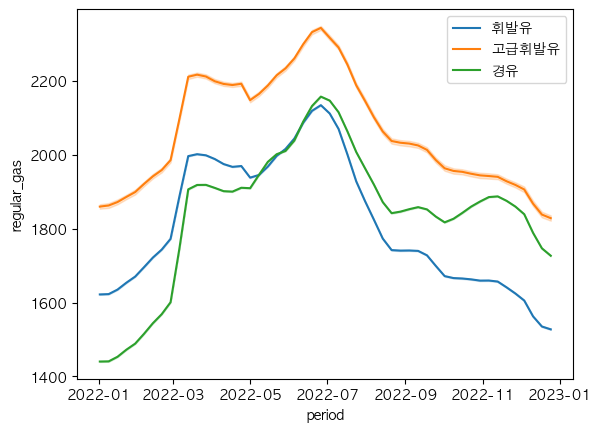

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x="period", y="regular_gas", data=df, label="휘발유")
sns.lineplot(x="period", y="premium_gas", data=df, label="고급휘발유")
sns.lineplot(x="period", y="diesel", data=df, label="경유")

plt.legend()
plt.show()


> 2월-3월 사이 유가가 급등한 이유는 러시아-우크라이나 전쟁 때문인 것으로 추정. <br/>
> 일반적으로 경유(diesel)가 휘발유(regular_gas)보다 저렴하지만, 5월 즈음 경유 가격이 휘발유 가격을 가격을 추월함. <br/>
> → 경유 가격 급등 현상의 상세 원인을 규명하기 위해 추가 데이터 수집해 분석해 볼 필요가 있음. <br/>


### 2) 지역 별 기름 값 분석
- 어느 지역의 기름이 가장 비싼가

In [67]:
# df.region.unique()

for r in df.region.unique():
    if(len(r.split()) != 2 ):
        print(r)

df.loc[df.region == '세종시', "region"] = "충남 세종시"

df["city"] = df.region.str.split().str[0]
df['gu'] = df.region.str.split().str[1]
df = df.drop(columns=["region"])

df.head(2)

세종시


,store_name,period,brand,is_self,premium_gas,regular_gas,diesel,city,gu
0,(주)강릉햇살 유천주유소,2022-01-02,현대오일뱅크,True,1769.0,1543.0,1375.86,강원,강릉시
1,(주)강릉햇살 유천주유소,2022-01-09,현대오일뱅크,True,1769.0,1543.0,1368.00,강원,강릉시


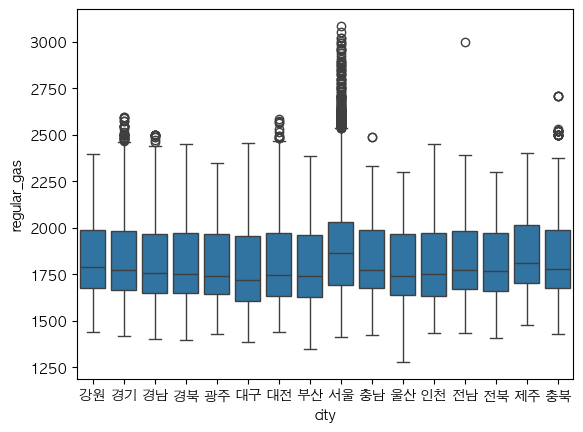

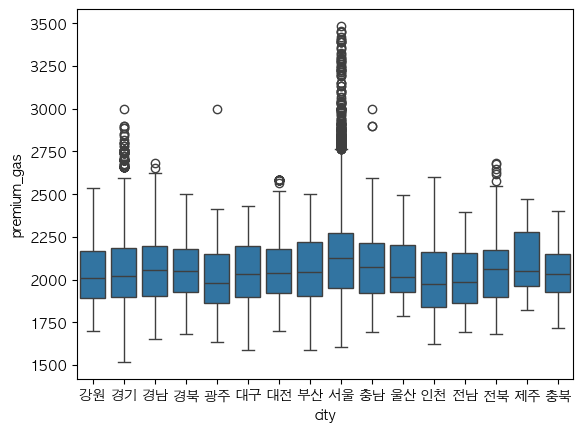

In [68]:
sns.boxplot(data=df, x="city", y="regular_gas")
plt.show()

sns.boxplot(data=df, x="city", y="premium_gas")
plt.show()

> 서울과 제주가 다른 지역에 비해 유가가 조금 높은 편임.


### 3) 브랜드별/지역별 주유소 기름 종류 비율
- 고급휘발유(premium_gas), 휘발유(regular_gas), 경유(diesel)

In [69]:
df.brand.unique()

array(['현대오일뱅크', 'S-OIL', 'SK에너지', 'GS칼텍스', '알뜰(ex)', 'NH-OIL', '자가상표',
       '알뜰주유소'], dtype=object)

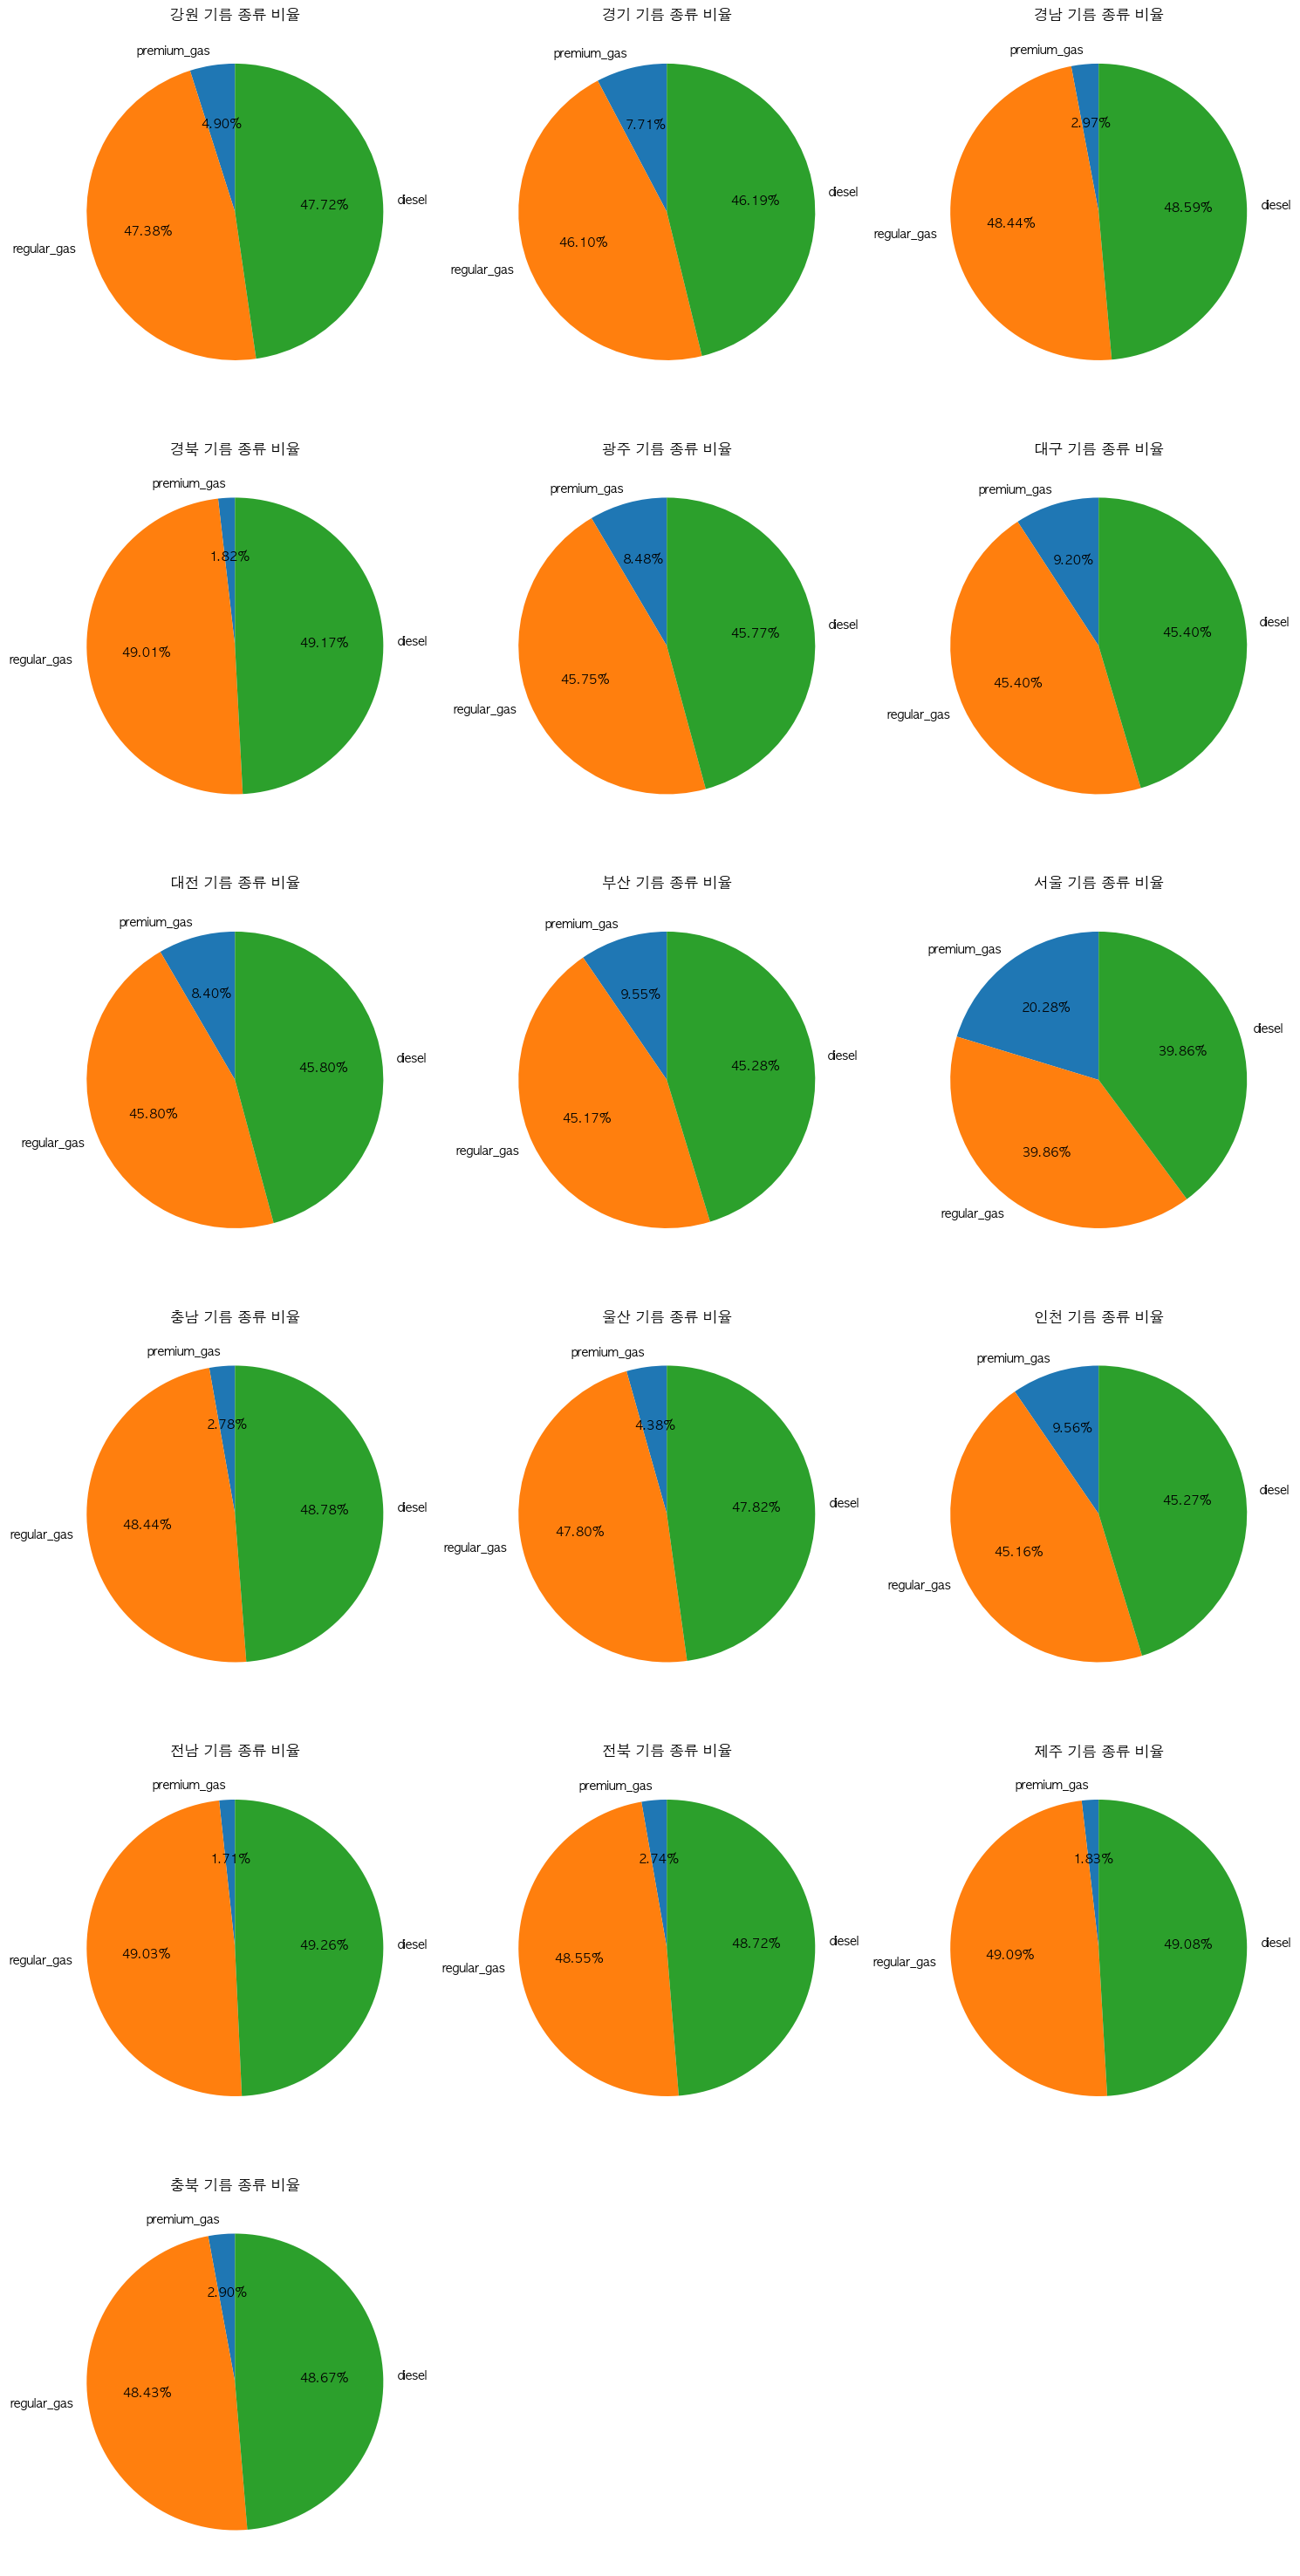

In [74]:
fuel_types = ['premium_gas', 'regular_gas', 'diesel']
city_fuel_ratios = {}

# 비율 계산
for city in df.city.unique():
    city_data = df[df['city'] == city]
    fuel_counts = city_data[fuel_types].count()
    total_count = fuel_counts.sum()
    city_fuel_ratios[city] = (fuel_counts / total_count) * 100

# Subplot 설정
n_cities = len(city_fuel_ratios)
n_cols = 3  # 한 줄에 3개
n_rows = (n_cities + n_cols - 1) // n_cols  # 행 자동 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

# 파이차트 그리기
for ax, (city, ratios) in zip(axes, city_fuel_ratios.items()):
    ax.pie(ratios, labels=fuel_types, autopct='%.2f%%', startangle=90)
    ax.set_title(f'{city} 기름 종류 비율')

# 남는 subplot 빈칸 삭제
for i in range(len(city_fuel_ratios), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [72]:
fuel_types = ['premium_gas', 'regular_gas', 'diesel']
brand_fuel_ratios = {}

for brand in df.brand.unique():
    brand_data = df[df['brand'] == brand]
    fuel_counts = brand_data[fuel_types].count()
    total_count = fuel_counts.sum()
    brand_fuel_ratios[brand] = (fuel_counts / total_count) * 100

# 수치 출력
for brand, ratios in brand_fuel_ratios.items():
    print(f"✅ {brand} 기름 종류 비율")
    print(ratios.round(2))  # 소수점 2자리까지 깔끔하게 출력
    print("-" * 30)


✅ 현대오일뱅크 기름 종류 비율
premium_gas     7.36
regular_gas    46.26
diesel         46.38
dtype: float64
------------------------------
✅ S-OIL 기름 종류 비율
premium_gas     3.23
regular_gas    48.27
diesel         48.51
dtype: float64
------------------------------
✅ SK에너지 기름 종류 비율
premium_gas     5.03
regular_gas    47.41
diesel         47.56
dtype: float64
------------------------------
✅ GS칼텍스 기름 종류 비율
premium_gas     9.16
regular_gas    45.39
diesel         45.45
dtype: float64
------------------------------
✅ 알뜰(ex) 기름 종류 비율
premium_gas     1.69
regular_gas    49.15
diesel         49.15
dtype: float64
------------------------------
✅ NH-OIL 기름 종류 비율
premium_gas     0.08
regular_gas    49.96
diesel         49.96
dtype: float64
------------------------------
✅ 자가상표 기름 종류 비율
premium_gas     0.97
regular_gas    48.03
diesel         51.00
dtype: float64
------------------------------
✅ 알뜰주유소 기름 종류 비율
premium_gas     2.27
regular_gas    48.86
diesel         48.86
dtype: float64
---------------------

> 서울, 인천, 부산 지역은 고급휘발유 판매 비율이 높으며, <br/>
> 이는 고급차 분포 특성과 관련 있을 가능성이 있다.<br/>
> 또한, 현대오일뱅크는 브랜드 중 고급휘발유 판매 비중이 가장 높았다.